# PyOmegaScan

## Table Of Contents

Welcome to the IPython Notebook of PyOmega! This notebook will take you through the wscan.py code to show you just how and why an omega scan is created. We hope to start a new era of clearly documented and user friendly code in LIGO. 

* [Acknowledgements](#Acknowledgements)
* [References](#References)
* [Installation](#Installation)
* [Introduction](#Introduction)
    * [Gravitational Wave Data](#Gravitational Wave Data)
    * [Match Filtering](#Match Filtering)
        * [Generating Waveform](#Generating Waveform)
    * [Unmodelled Match Filtering](#Unmodelled Match Filtering)

<a id='Acknowledgements'></a>
## Acknowledgements

A huge thank you is owed to two people. First, Duncan Macleod for his work on GWpy which is utilized extensively throughout wscan.py. Please visit the [GWpy](https://gwpy.github.io/) site. Also, for his work on editing wscan.py and incoporating it into the larger GWpy framework. Second, Chris Pankow for his extensive use of iPython notebook from which I definitely copied some very well written and useful text.

<a id='References'></a>
## References

* [Multiresolution techniques for the detection of gravitational-wave bursts](http://www.mit.edu/~kats/publications/pub55_class_quant_grav_21_20_s1809_2004.pdf)
* [Shourov Chatterji Thesis](http://dspace.mit.edu/handle/1721.1/34388)

<a id='Installation'></a>
## Installation of Packages

First, we must import a number of packages some of which are native to python and some which require installation.

I suggest following the [GWpy Install Guide](https://gwpy.github.io/docs/v0.1/install.html)

In [2]:
from __future__ import division

import sys
import os
import random
import string
import shutil
import ConfigParser
import optparse
import json
import rlcompleter
import pdb

import pandas as pd
import numpy as np

from scipy import signal
from scipy.interpolate import InterpolatedUnivariateSpline

from matplotlib import (pyplot as plt, cm)
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from gwpy.plotter import rcParams
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from glue import datafind

from gwpy.timeseries import TimeSeries

#FIXME: Importing ML does not currently work

#import .src.ML.make_pickle_for_linux as make_pickle
#import ML.labelling_test_glitches as label_glitches

pdb.Pdb.complete = rlcompleter.Completer(locals()).complete

<a id='Introduction'></a>
## Introduction

In this section, we hope to give the user a sense of the data that comes out of the gravitational wave detector and what rudimentary ways we can visualize the raw data. After this discussion, we will motivate a more sophisticated way of visualizing the data that is quantified through an omega scan.

<a id='Gravitational Wave Data'></a>
## Gravitational Wave Data

Let us start by taking some of the data from the detector and plotting it.

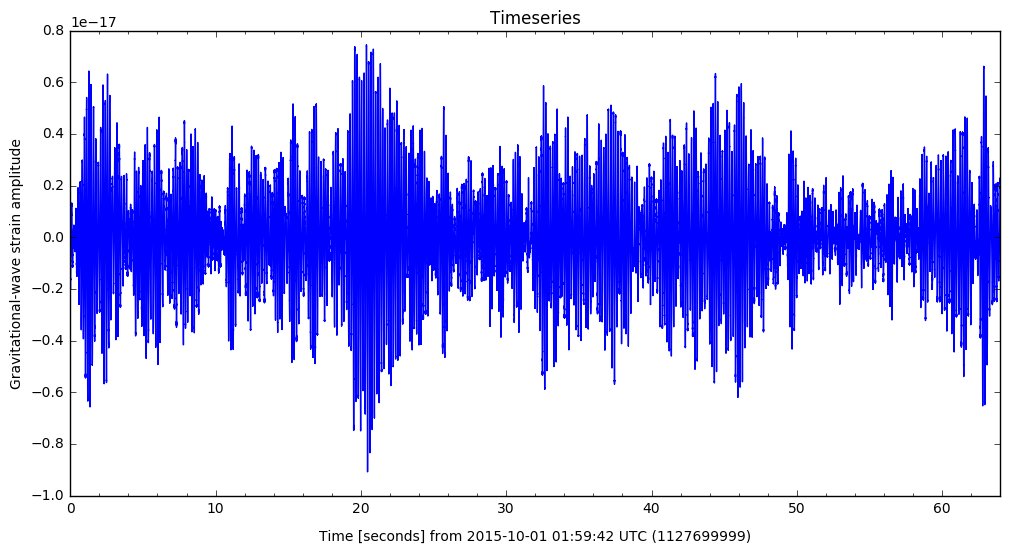

In [4]:
%matplotlib inline

# Pick the start and stop times and a channel name from which to read the data
startTime   = 1127699999.0
stopTime    = 1127700063.0
channelName = 'L1:GDS-CALIB_STRAIN'
detector    = 'L'
frameType   = 'L1_HOFT_C00'

# Read in the data

NSDF = 0
if NSDF:
    data = TimeSeries.fetch(channelName,startTime,stopTime)
else:
    connection = datafind.GWDataFindHTTPConnection()
    cache = connection.find_frame_urls(detector, frameType, startTime, stopTime, urltype='file')
    data = TimeSeries.read(cache,channelName, format='gwf',start=startTime,end=stopTime)

# resample data if necessary
sampleFrequency = 4096
if data.sample_rate.decompose().value != sampleFrequency:
    data = data.resample(sampleFrequency)
    
plot = data.plot()
plot.set_title('Timeseries')
plot.set_ylabel('Gravitational-wave strain amplitude')
plot.show()


This visualization is not very helpful. Perhaps, we can simple look at the spectrogram of the data above. Essentially, the would require performing a fast fourier transform on the timeseries data in order to visualize it on what can also be called a Time-Frequency Map where the coloring of the map is the amplitude of the Gravtioanl Wave data. As shown in [GWpy Spectrogram Example](https://gwpy.github.io/docs/v0.1/examples/spectrogram/plot.html)
We will use 2 second long FFT with a 50 percent (1 second) overlap between segments. In addition we will use a stride of 5.

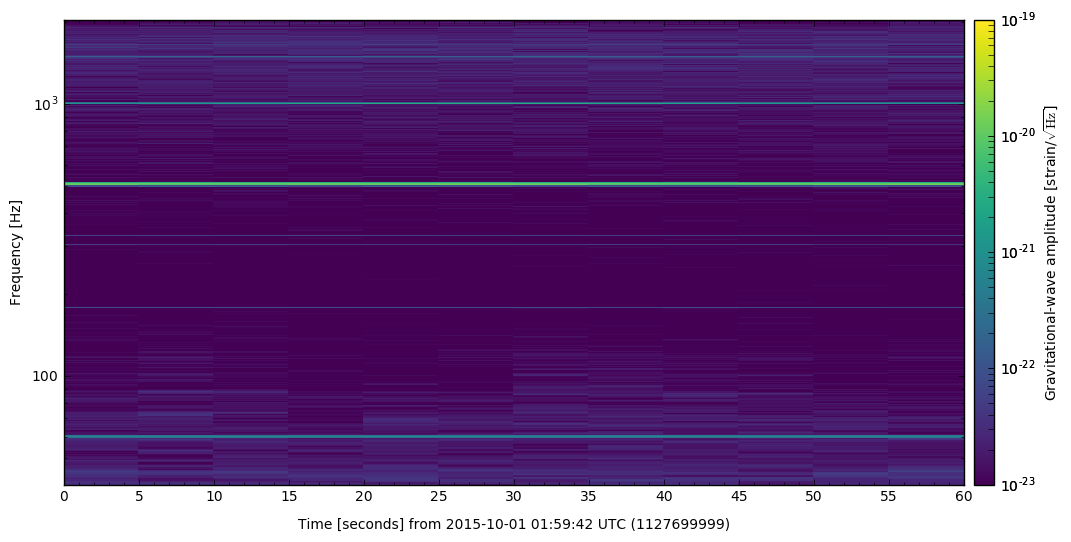

In [5]:
specgram = data.spectrogram(5, fftlength=2, overlap=1) ** (1/2.)
plot = specgram.plot(norm='log', vmin=1e-23, vmax=1e-19)
plot.set_yscale('log')
plot.set_ylim(40, 2048)
plot.add_colorbar(
    label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]',cmap='viridis')

It appears clear from both the time series and the spectrogram of the raw data that no important discerning features can be achieved from looking only at the raw data. Importantly, it looks like most of our noise is from loud lines in the data, so 500 100 1500 Hz (Violin Mode Harmonics) and 60 Hz (the Powerline) and its harmonics.

<a id='Match Filtering'></a>
## The Concept of Match-Filtering

It is clear that we must come up with a good way to manipulate the data such that we can pull out signal from the data. One can imagine doing a match-filter to accomplish this task. Essentially, we simulate what the signal should look like and take the inner produce of it with your data. If your data and simulated signal are a good match then the numerical value that results should be high! Mathematically, this would look as follows.

$$
\tilde{d}(f)\cdot\tilde{h}_T(f) \equiv \int \tilde{d}(f) \tilde{h}_T(f)^{\star} df
$$

where $\tilde{h}_T(f)$ is your simulated signal

<a id='Generating Waveform'></a>
## Generating Waveform

So let us attempt just that, generating a simulated gravitational wave.

Help on built-in function SimInspiralFD in module _lalsimulation:

SimInspiralFD(...)
    SimInspiralFD(REAL8 m1, REAL8 m2, REAL8 S1x, REAL8 S1y, REAL8 S1z, REAL8 S2x, REAL8 S2y, REAL8 S2z, REAL8 distance, REAL8 inclination, REAL8 phiRef, REAL8 longAscNodes, REAL8 eccentricity, REAL8 meanPerAno, REAL8 deltaF, REAL8 f_min, REAL8 f_max, REAL8 f_ref, Dict LALparams, Approximant approximant) -> int



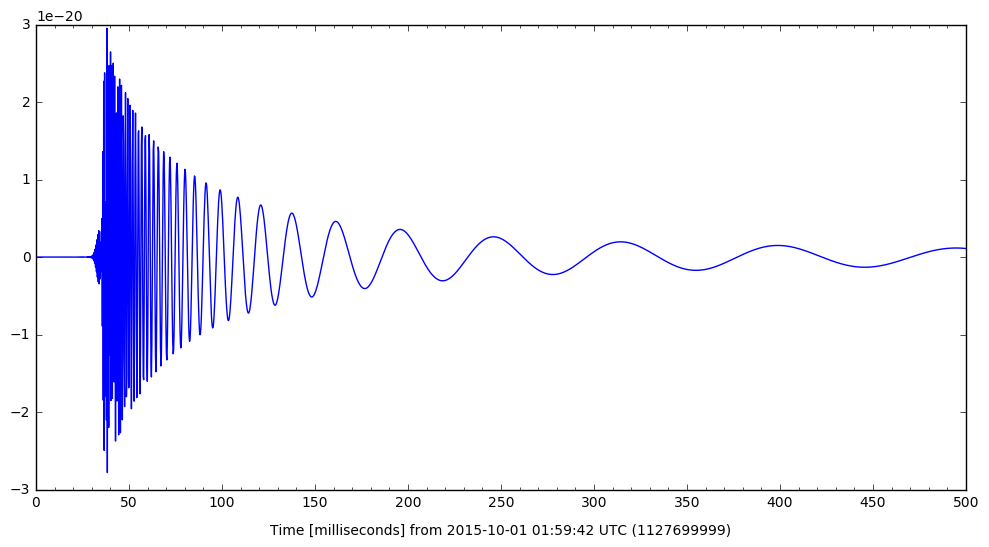

In [10]:
import lal
import lalsimulation
# Generate waveforms
# This function takes in a bunch of parameters  and generates the frequency domain waveforms
# Intrinsic parameters:
# component masses in kg
m1, m2 = 15 * lal.MSUN_SI, 15 * lal.MSUN_SI
# component spins (Cartesian, normalized to be unitless)
s1x, s1y, s1z = 0.0, 0.0, 0.0
s2x, s2y, s2z = 0.0, 0.0, 0.0

# Extrinsic parameters
# coalescence phase and polarization angle
coa_phase, polarization_angle = 0.0, 0.0
# sky position
ra, dec = 0.0, 0.0
# distance in m and inclination
dist, incl = 1e6 * lal.PC_SI, 0.0

# waveform model to use
approx1 = lalsimulation.SEOBNRv2

# We are doing a discrete set of dF not an infinite as the equation above shows
delta_f = 0.125
flow = 20
fmax = fnyq = 2048
samp_rate = 2* fnyq

# We're actually doing a numerical integral so df -> \delta f
delta_f = 0.125

help(lalsimulation.SimInspiralFD)
hpf, hxf = lalsimulation.SimInspiralFD(
                            m1, m2,
                            s1x, s1y, s1z,
                            s2x, s2y, s2z,
                            dist, incl, coa_phase,
                            0.0,0.0,0.0, 
                            delta_f, flow, fmax, flow,
                            None,approx1)

# For convenience, we'll reuse hpf and redefine to be h1
hpf.data.data += hxf.data.data
h1 = hpf

GWsim = TimeSeries(h1.data.data.real,sample_rate=samp_rate,epoch=startTime)
GWsim =GWsim[0:2048]
plot = GWsim.plot()
plot.save('GWsimulation.png')

As with the timeseries data let us visualize this as a spectrogram. 

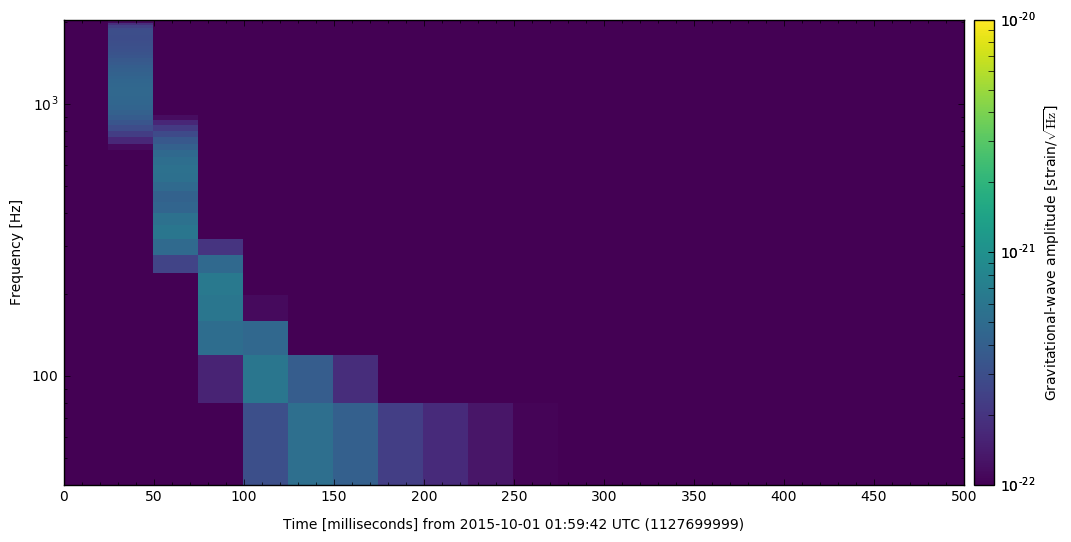

In [11]:
specgram = GWsim.spectrogram(0.025, fftlength=0.025, overlap=0.0125) ** (1/2.)
plot = specgram.plot(norm='log', vmin=1e-22, vmax=1e-20)
plot.set_yscale('log')
plot.set_ylim(40, 2048)
plot.add_colorbar(
    label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]',cmap='viridis')

The overlap itself adds a weighting to each frequency component of the waveforms indicating how "sensitive" the detector is to that frequency. The sensitvity function is the power spectral density $S(f)$. So, the overlap is proportional to:

$$
\left(\tilde{h}_1(f)|\tilde{h}_2(f)\right) \propto 4 \int_0^{\infty} \frac{\tilde{h}_1(f) \tilde{h}_2(f)^{\star}}{S(f)} df
$$

Thus, we come up with the terminalogy of Signal (numerator: inner product) to Noise (denominator: average characterization of the noise). This value we call the SNR.

<a id='Unmodelled Match Filtering'></a>
## Unmodelled Match-Filtering

For our purposes, this process as implemented above does not work because we are attempting to extract features from an unmodelled signal. This begs the question how can we adapt the above for our purposes.

From the Q-scan paper: "In general, a search algorithm for [unmodelled] gravitational-wave projects the data under test onto a basis constructed to span the space of plausible bursts"

So, what does that mean, exactly? Basically, "unmodelled" does not mean "unkown". We have very reasonable expectations for what the signal should look like very roughly.

One therefore could imagine defining a number of parameters, such as central time, central frequency, duration, and bandwidth, which characterize the structure of bursts that would exists within the constraints of a time frequency spectrogram like the one plotting at the beggining of the iPython notebook.

*THIS* is our "simulated signal" so to speak. Therefore, we can imagine tweaking our beautiful match-filter equation from above:

$$
\int_0^{\infty} \frac{\tilde{d}(f) \tilde{h}(f_c,t_c,dur,band)^{\star}}{S(f)} df
$$

So, if we got lucky and exactly parameterized the characteristics of the burst signals then this equations would become

$$
\int_0^{\infty} \frac{\tilde{d}^2(f)}{S(f)} df
$$

So what do we got to do! We have to attempt to parameterize the burst signal in the best possible way, because, if we do not, the parameterization encompasses either too little signal or too much noise, resulting
in a loss in the measured signal-to-noise ratio. 

So what naturally characterizes a burst signal? Their Q!

Wait a second, what is "their Q"?

The dimensionless quality factor Q for unmodelled GWs is the ratio of center frequency to bandwidth:

$$
Q = \frac{f_c}{band}
$$

In other words, the dimensionless quality factor Q is essentially a measure of the signal's aspect ratio in
the time-frequency plane and is roughly equal to the number of oscillations of the time-domain waveform over the duration of the burst.


Since bursts are naturally characterized by their
Q, we therefore choose to tile the time–frequency plane by selecting a measurement basis
which directly targets bursts within a finite range of
Q. This naturally leads to a logarithmic
tiling of the time–frequency plane in which individual measurement pixels are well-localized
signals, all with the same Q.

Thus,  the Q transform at a specific frequency is obtained by a standard Fourier transform
of the original time series, a shift in frequency, multiplication by the appropriate frequency
domain window function, and an inverse Fourier transform.